# Постановка задачи
В качестве экзамена вам необходимо решить реальный аналитический кейс, который переложен на данные нашего учебного сайта. 

Вам необходимо выяснить, **пользователи с какими устройствами приносят наибольший доход**. Под доходом мы подразумеваем ARPU (Average Revenue Per User), то есть отношение выручки к размеру аудитории. Таким образом, результатом решения кейса будет конкретная модель устройства.
Какие данные у нас есть
1. Выгрузка  с доходом от рекламы сайта в разбивке по моделям устройств 
Данные по рекламным доходам arpu_revenue_data.csv

В этой выгрузке уже просуммирован общий доход (revenue) по каждому устройству за март 2018 года.

Каждое устройство идентифицируется с помощью трех колонок: mobilePhone, mobilePhoneModel и deviceCategory.

2. Данные Яндекс.Метрики по суточной аудитории сайта в разбивке по устройствам

Эти данные вам необходимо получить по API. Номер счетчика учебного сайта для выгрузки данных из Яндекс.Метрики: 21075004

Набор измерений и метрик для получения отчета Яндекс.Метрики 
'ym:s:date', 'ym:s:deviceCategory', 'ym:s:mobilePhone', 'ym:s:mobilePhoneModel', 'ym:s:users'

Ваша задача
1. Собрать данные о доходах и данные об аудитории в единый отчет

2. Посчитать метрику ARPU по каждому устройству 

ARPU =  revenue/ суммарное количество пользователей

3. Найти модель устройства с наибольшим ARPU

В качестве ответа онлайн-проверка ожидает получить название модели телефона, которой соответствует максимальное значение ARPU. Т. е. если вы получили, например, максимальное значение ARPU для такого устройства:

deviceCategory: Смартфоны

mobilePhone: Sony

mobilePhoneModel: Xperia Z

то в онлайн-проверку надо вставить Xperia Z

Несколько важных замечаний
- При расчете суточной аудитории необходимо учитывать только те устройства, которыми за март пользовались не менее 3 пользователей (т. е. сумма суточной аудитории составила 3 и более пользователей)
- Чтобы получить общую аудиторию за месяц по конкретному устройству, необходимо суммировать количество пользователей за каждый день этому устройству
- Поскольку задание максимально приближено к "боевым" условиям учитывайте тот факт, что у Метрики есть ограничение по количеству запросов -  и если ваши коллеги его исчерпают, то вы можете не получить выгрузку. В этом случае, попробуйте повторить обращение через некоторое время!

Мы создали специальный канал в Slack для ваших вопросов. #exam
Мы уверены, что вы успешно справитесь с этой задачей!

In [1]:
import os
import re
import requests

import yaml
import pandas as pd
import numpy as np

%matplotlib inline

## ARPU dataset

In [2]:
path_arpu = './exam_files/arpu_revenue_data.csv'

arpu_data = pd.read_csv(path_arpu, '\t')

In [3]:
arpu_data.head()

,mobilePhone,mobilePhoneModel,deviceCategory,revenue
0,4Good,Light A104,Смартфоны,"0,987567486"
1,Acer,B1-750,Планшеты,"0,952423812"
2,Acer,E39,Смартфоны,"5,240945719"
3,Acer,T02,Смартфоны,"2,637776834"
4,Acer,T03,Смартфоны,"1,020764495"


In [4]:
arpu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 4 columns):
mobilePhone         738 non-null object
mobilePhoneModel    738 non-null object
deviceCategory      738 non-null object
revenue             738 non-null object
dtypes: object(4)
memory usage: 23.1+ KB


In [5]:
arpu_data.shape

(738, 4)

Как видно, тип данных столбца revenue - object, приведем к float:

In [6]:
arpu_data['revenue'] = arpu_data['revenue'].str.replace(',', '.').astype(float)

In [7]:
arpu_data['mobilePhoneModel'].value_counts().head(10)

None                7
BND-L21             2
Tab_2               2
Lumia 640           2
Galaxy S8           2
Lumia 630           2
Lumia 530           1
X5max_PRO           1
CRO-L22             1
Ixion X LTE 4.5"    1
Name: mobilePhoneModel, dtype: int64

В данных есть пропуски и повторы моделей телефонов

In [8]:
arpu_data.iloc[:, :-1] = arpu_data.iloc[:, :-1].applymap(lambda x: 'undefined' if ('None' in x) or x==None else x)

In [9]:
arpu_data.shape

(738, 4)

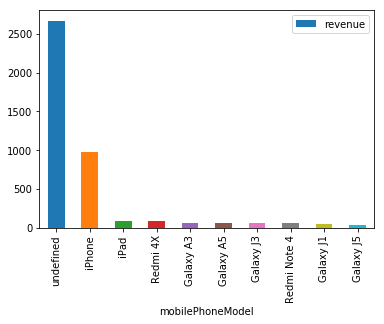

In [10]:
arpu_data.sort_values(by='revenue', ascending=False).head(10).plot(x='mobilePhoneModel', y='revenue', kind='bar');

Большая часть выручки в выборке приходится на модели с неопределенным наименованием

In [11]:
arpu_data.isna().any()

mobilePhone         False
mobilePhoneModel    False
deviceCategory      False
revenue             False
dtype: bool

## Yandex API

In [12]:
dimensions = ['ym:s:date', 
              'ym:s:deviceCategory', 
              'ym:s:mobilePhone', 
              'ym:s:mobilePhoneModel']
metrics = ['ym:s:users']

with open('../module12/module12_files/yandex_config.yaml') as f:
    yandex_token = yaml.load(f)['access_token']

api_url = 'https://api-metrika.yandex.ru/stat/v1/data'
startDate, endDate = '2018-03-01', '2018-03-31'
counter = '21075004'

params = {
    'date1': startDate,
    'date2': endDate,
    'dimensions': ','.join(dimensions),
    'metrics': ','.join(metrics),
    'id': counter,
    'oauth_token': yandex_token,
    'limit': 3000,
    'accuracy': 1
}

In [13]:
def make_request(**kwargs):
    return requests.get(api_url, params=kwargs).json()

def json_handler(data):
    """Преобразование ответа из JSON в список"""
    report = []
    for line in data['data']:
        line_metrics = line['metrics']
        line_dimensions = [value['name'] for value in line['dimensions']]
        report.append(line_dimensions + line_metrics)
        
    return report

In [14]:
yandex_raw_data = make_request(**params)

In [15]:
columns = [i[5:] for i in dimensions + metrics]
# columns = dimensions + metrics
yandex_data = pd.DataFrame(json_handler(yandex_raw_data), columns=columns)

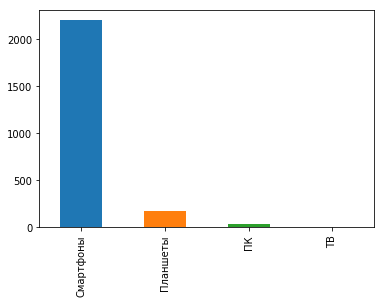

In [16]:
yandex_data['deviceCategory'].value_counts().plot(kind='bar');

## Промежуточная проверка

#### Проверка 1
(1 балл из 1)
После выгрузки отчета из Яндекс.Метрики вы получили статистику суточной аудитории в разбивке по типу, модели и производителям устройств.

Чему равна сумма пользователей во всех строчках отчета из Яндекс.Метрики?

In [17]:
yandex_data['users'].sum()

7167.0

#### Проверка 2
(1 балл из 1)
После импорта данных по выручке из файла arpu_revenue_data.csv столбец с выручкой revenue необходимо перевести в тип float.

Какова сумма значений этого столбца? Ответ округлите до ближайшего целого числа.

In [18]:
round(arpu_data['revenue'].sum(), 0)

5801.0

#### Проверка 3
(1 балл из 1)
Перед тем как совместить выгрузку Яндекс.Метрики и данные по выручке необходимо сделать 2 операции:

1. Сгруппировать выгрузку Яндекс.Метрики по 'deviceCategory', 'mobilePhone', 'mobilePhoneModel', чтобы просуммировать значения по дням (т. к. значения по выручке известны только в сумме за март).

2. После группировки оставить только те строки получившейся таблицы, в которых оказалось 3 и более пользователей.

Сколько строк останется в выгрузке Яндекс.Метрики после этих действий?

### >>>>>>>>>Groupby пропускает тип NaN!<<<<<<

In [19]:
yandex_data.fillna('undefined', inplace=True)

categorical = ['deviceCategory', 
               'mobilePhone', 
               'mobilePhoneModel']
ya_users_sum = (yandex_data.groupby(categorical)['users']
                 .sum()
                 .reset_index())

ya_users_sum = ya_users_sum[ya_users_sum['users'] >= 3]
ya_users_sum.shape

(242, 4)

#### Проверка 4
(1 возможный балл)
После совмещения выгрузок Яндекс.Метрики и файла с выручкой надо посчитать значение ARPU для каждой строки получившегося датафрейма. Можно использовать метод apply + отдельную функцию. Или использовать метод apply с lambda-функцией. Обратите внимание, что столбец 'revenue' не всегда автоматически распознается как тип float.

Какое значение ARPU получится у строки с категорией устройства 'ПК' (модель и тип устройства при этом будут не определены)? Ответ округлите до двух знаков после запятой. Формат ответа: 0.84

In [20]:
ya_users_sum.head()

,deviceCategory,mobilePhone,mobilePhoneModel,users
0,ПК,undefined,undefined,2715.0
7,Планшеты,Apple,iPad,96.0
17,Планшеты,Explay,sQuad 7.82 3G,5.0
18,Планшеты,Google,Nexus 7,3.0
19,Планшеты,Huawei,AGS-L09,7.0


In [21]:
arpu_data.head()

,mobilePhone,mobilePhoneModel,deviceCategory,revenue
0,4Good,Light A104,Смартфоны,0.987567
1,Acer,B1-750,Планшеты,0.952424
2,Acer,E39,Смартфоны,5.240946
3,Acer,T02,Смартфоны,2.637777
4,Acer,T03,Смартфоны,1.020764


In [22]:
ya_users_sum.shape, arpu_data.shape

((242, 4), (738, 4))

In [23]:
merged_data = arpu_data.merge(ya_users_sum, how='left', on=categorical)
merged_data['ARPU'] = merged_data.apply(lambda x: x['revenue'] / x['users'], axis=1)

In [24]:
merged_data[merged_data.deviceCategory=='ПК']

,mobilePhone,mobilePhoneModel,deviceCategory,revenue,users,ARPU
465,undefined,undefined,ПК,2667.568827,2715.0,0.98253


# Итоговый результат экзамена
(1 балл из 1)
Наконец, сортируем получившийся датафрейм по убыванию столбца с вычисленным значением ARPU. И проверяем какая модель устройства mobilePhoneModel имеет максимальный ARPU:

In [33]:
merged_data.sort_values(by='ARPU', ascending=False)['mobilePhoneModel'].iloc[0]

'AGS-L09'